# Data Scraping (Reviews)

Despite of being a tropical country, few ice skating rinks exists in the Philippines mainly in selected SM Branches. Many people visited those places and tried ice skating. Some of them left reviews and ratings about the place and their overall experience.

Thus, for investigatory purposes, I am scraping their reviews in search of questions this main question:

**Do I expect a good time ice skating here?**

However, other questions can be formulated as well.
Aside from those, the data might provide more detailed information.

The reviews are scraped from **Google Maps**.

In [ ]:
!pip install selenium
!pip install pandas
!pip install beautifulsoup4

In [5]:
# For interaction with operating system
import os

# For data structure, manipulation, and viewing
import pandas as pd

# For datetime
from datetime import datetime, timedelta

# For using sleep()
import time

# For data scraping (interaction with Javascript components and extracting the contents of elements)
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup

## Google Maps Review

### Initiating the webdriver

In [4]:
driver = webdriver.Chrome() # Chrome driver instance
url = 'https://www.google.com/maps/place/SM+Skating/@14.5350532,120.9788464,17.25z/data=!4m18!1m9!3m8!1s0x3397cbfb85da4983:0xa331ff7273c2a148!2sSM+Skating!8m2!3d14.5349871!4d120.981629!9m1!1b1!16s%2Fg%2F11xdmldgj!3m7!1s0x3397cbfb85da4983:0xa331ff7273c2a148!8m2!3d14.5349871!4d120.981629!9m1!1b1!16s%2Fg%2F11xdmldgj?entry=ttu'
driver.get(url) # Open the driver and go to the URL
driver.maximize_window() # Maximize Chrome window

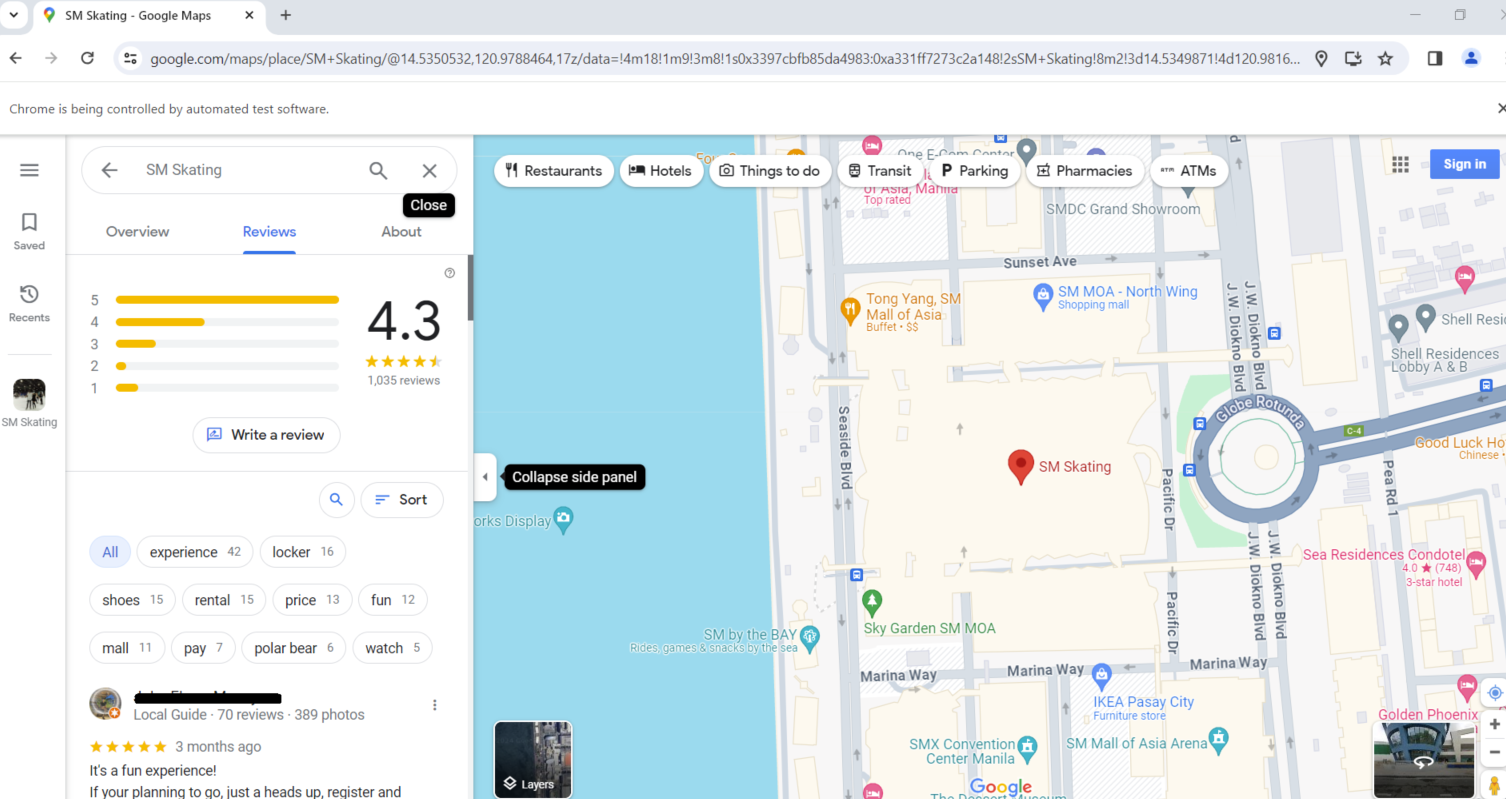

After running the script from the previous cell, it opens Google Chrome and redirects to the URL provided. As can be seen, there are 1035 reviews and each review is located on a left side pane of the Google Map web application.

### Scrolling and Revealing Full Reviews

There are two (2) obstacles for data scraping in this situation:
* Limited amount of reviews are only displayed initially and scrolling down further loads other comments.
* There are reviews that are too long to be displayed completely by Google Maps making it required to click "More" to expand the full review text.

To shoot two birds with one stone, the comments' section can be scrolled down using Selenium. Also, as the automated scrolling is running, those "More" buttons must be clicked to fully show the review text. Thus, their presence need to be checked out for every scroll and once found, must be automatically clicked.

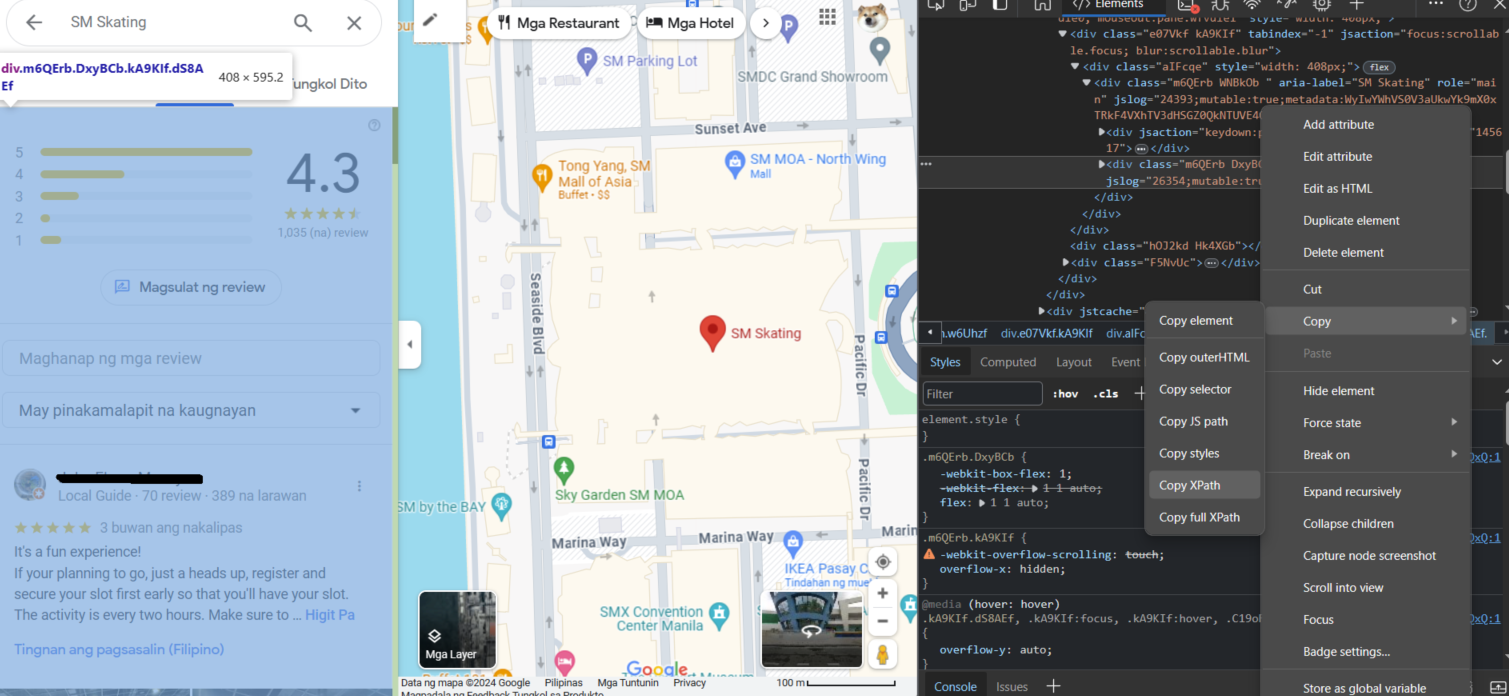

In [354]:
last_height = driver.execute_script("return document.body.scrollHeight") # Initial scroll height

# Since the end is unknown, infinite while-loop to scroll down until the end.
while True:

    to_click = driver.find_elements(By.CLASS_NAME, 'w8nwRe') # Look for the buttons (e.g, "More", "Higit Pa", etc.) to expand review texts
    
    # Click each button
    for i in to_click:
        i.click()
    
    # Scroll down
    # The value of y-coordinate (in this case is 5000) is arbitrary. It was set to 5000 to scroll down to the bottommost reviews and trigger the loading of other comments
    # The XPATH of the <div> shown from the image above was located in order to perform the scrolling
    ele = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')
    driver.execute_script('arguments[0].scrollBy(0, 5000);', ele)

    # Set a buffer of 5 seconds before the next action to possible errors due to fast actions made by Selenium
    time.sleep(5)

    # After scrolling, find the scroll height and set it as the new scroll height
    ele = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')
    new_height = driver.execute_script("return arguments[0].scrollHeight", ele)

    # Display last and new scroll height to verify if the scrolling is working fine
    print(f"Last Scroll Height = {last_height} ; New Scroll Height = {new_height}")

    # If there are no changes in the new height, there are no more reviews to scroll. Thus, break the infinite loop
    if new_height == last_height:
        print("Reached the end")
        break
    
    # Set the last height to the new height
    last_height = new_height

Last Scroll Height = 686 ; New Scroll Height = 9979
Last Scroll Height = 9979 ; New Scroll Height = 15719
Last Scroll Height = 15719 ; New Scroll Height = 21500
Last Scroll Height = 21500 ; New Scroll Height = 25404
Last Scroll Height = 25404 ; New Scroll Height = 29328
Last Scroll Height = 29328 ; New Scroll Height = 34038
Last Scroll Height = 34038 ; New Scroll Height = 36928
Last Scroll Height = 36928 ; New Scroll Height = 39907
Last Scroll Height = 39907 ; New Scroll Height = 43600
Last Scroll Height = 43600 ; New Scroll Height = 46790
Last Scroll Height = 46790 ; New Scroll Height = 49368
Last Scroll Height = 49368 ; New Scroll Height = 51883
Last Scroll Height = 51883 ; New Scroll Height = 54567
Last Scroll Height = 54567 ; New Scroll Height = 56998
Last Scroll Height = 56998 ; New Scroll Height = 60000
Last Scroll Height = 60000 ; New Scroll Height = 62051
Last Scroll Height = 62051 ; New Scroll Height = 64693
Last Scroll Height = 64693 ; New Scroll Height = 66681
Last Scroll He

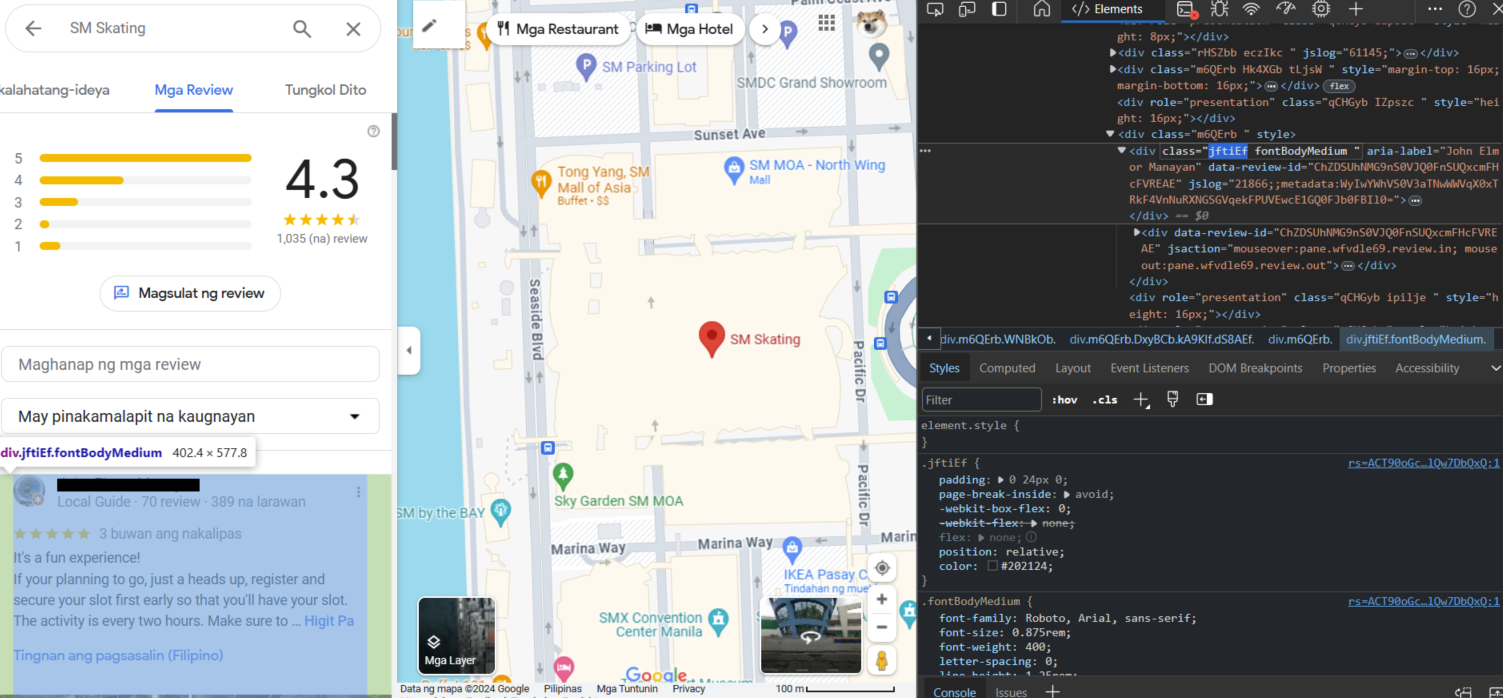

### Extracting the reviews from the contents of the webpage

BeautifulSoup will be used to get the source code of the scrolled down webpage, parse it, and select the elements that contains review data. It also displays the total number of reviews for confirmation.

In [355]:
time.sleep(5)

# Scroll back up to the upper most part of the reviews section
# This might not be needed as BeautifulSoup will be used to extract all of the contents of all reviews
ele = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')
driver.execute_script(f'arguments[0].scrollBy(0, -{str(last_height)});', ele)

time.sleep(5)

# Extract all of the <div> with class name of "jftiEf" which corresponds to the <div> containing all information from each review
# The image above shows the class name of the <div> using "Inspect Element" tool from the browser
# The class name is the same for all review <div>
all_reviews = BeautifulSoup(driver.page_source, 'html.parser').find_all('div', class_ = 'jftiEf')
# Confirm the number of reviews extracted
print(f"Total number of reviews: {len(all_reviews)}")

Total number of reviews: 1035


The number of scraped review data matches the number of reviews displayed on the web page (i.e., 1035).

### Selection of review data and creating the results

To implement anonimity, the name reviewer names will be excluded and the following review data will be collected:
* Review Time Ago - When the review was made with respect to the current date
* Review Text - The actual reviews text left by the reviewers
* Review Rating - The number of stars given by the reviewers

In [356]:
# Create a DataFrame containing only the following:

results_df = pd.DataFrame({
    'review_time_ago' : [x.find('span', class_ = 'rsqaWe').text for x in all_reviews], # Review Time Ago
    'review_text' : [x.find('span', class_ = 'wiI7pd').text if x.find('span', class_ = 'wiI7pd')!=None else None for x in all_reviews], # Review Text
    'review_rating' : [x.find('span', class_ = 'kvMYJc')['aria-label'] for x in all_reviews] # Review Rating
})

results_df

,review_time_ago,review_text,review_rating
0,3 months ago,It's a fun experience!\nIf your planning to go...,5 stars
1,3 months ago,"If you go there, bring your own skates. They h...",2 stars
2,a month ago,Nice this is price\n2 hours 350\nBear 125\nLoc...,5 stars
3,11 months ago,Ambience: the place is festive and properly li...,4 stars
4,11 months ago,It was my first time to do ice skating. It was...,4 stars
...,...,...,...
1030,2 years ago,None,5 stars
1031,3 years ago,None,3 stars
1032,5 years ago,None,5 stars
1033,2 years ago,None,3 stars


In [ ]:
driver.quit() # Close the Chrome driver

In [6]:
"""
Function that converts a year/month/day ago to 1 year/month/day ago"
"""
def uniform_review_time_ago(review_time_ago):
    if review_time_ago.split(' ')[0] == 'a': # Check if the first character of the split is "a"
        last_two_split = review_time_ago.split(' ')[1:] # Get the last two element splits
        return ' '.join(['1'] + last_two_split) # Concatenate with '1'
    
    return review_time_ago

In [358]:
# Map the "review_time_ago" column to uniform_review_time_ago() to fix instances such as "a year ago", "a month ago", "a week ago", "a day ago"
# Example: "a year ago" -> "1 year ago"
results_df['review_time_ago'] = results_df['review_time_ago'].map(uniform_review_time_ago)
results_df

,review_time_ago,review_text,review_rating
0,3 months ago,It's a fun experience!\nIf your planning to go...,5 stars
1,3 months ago,"If you go there, bring your own skates. They h...",2 stars
2,1 month ago,Nice this is price\n2 hours 350\nBear 125\nLoc...,5 stars
3,11 months ago,Ambience: the place is festive and properly li...,4 stars
4,11 months ago,It was my first time to do ice skating. It was...,4 stars
...,...,...,...
1030,2 years ago,None,5 stars
1031,3 years ago,None,3 stars
1032,5 years ago,None,5 stars
1033,2 years ago,None,3 stars


In [9]:
"""
Function that finds the previous year given the n-years/n-months/n-days ago based on the current date
"""
def find_review_year(review_time_ago):
    time_period_type = review_time_ago.split(' ')[1] # (e.g., years, months, weeks, days, etc.)
    time_value = int(review_time_ago.split(' ')[0]) 

    date_today = datetime.today().date() # Get current date

    # Return the year when the review was made by getting difference of current date with the given time value and period type

    if (time_period_type == 'hours') or (time_period_type == 'hour'):
        previous_date = date_today - timedelta(hours=time_value)
        return previous_date.year

    if (time_period_type == 'days') or (time_period_type == 'day'):
        previous_date = date_today - timedelta(days=time_value)
        return previous_date.year

    if (time_period_type == 'weeks') or (time_period_type == 'week'):
        previous_date = date_today - timedelta(weeks=time_value)
        return previous_date.year

    if (time_period_type == 'months') or (time_period_type == 'month'):
        previous_date = date_today - timedelta(days=time_value*30)
        return previous_date.year
    
    if (time_period_type == 'years') or (time_period_type == 'year'):
        previous_date = date_today - timedelta(days=time_value*365)
        return previous_date.year

In [360]:
# Map "review_year" column to find_review_year() and create a new column with the actual year when the review was made
results_df['review_year'] = results_df['review_time_ago'].map(find_review_year)
results_df

,review_time_ago,review_text,review_rating,review_year
0,3 months ago,It's a fun experience!\nIf your planning to go...,5 stars,2024
1,3 months ago,"If you go there, bring your own skates. They h...",2 stars,2024
2,1 month ago,Nice this is price\n2 hours 350\nBear 125\nLoc...,5 stars,2024
3,11 months ago,Ambience: the place is festive and properly li...,4 stars,2023
4,11 months ago,It was my first time to do ice skating. It was...,4 stars,2023
...,...,...,...,...
1030,2 years ago,None,5 stars,2022
1031,3 years ago,None,3 stars,2021
1032,5 years ago,None,5 stars,2019
1033,2 years ago,None,3 stars,2022


In [363]:
# Save the results DataFrame as a CSV file
folder_path = os.path.join(os.getcwd(), 'dataset')
os.makedirs(folder_path, exist_ok=True)
filename = 'google_review_ice_skating_moa.csv'
filepath_to_save_to = os.path.join(folder_path, filename)
results_df.to_csv(filepath_to_save_to, index=False)

### Application to other branches

Now, do the exact procedures for a different branch. We create a helper function that accepts a URL from an ice skating branch in Google Maps, specifically under "Review" tab then returns a DataFrame containing the scraped data.

Aside from MOA branch, there are Megamall and Seaside City (Cebu) branches.

Note: The URL must be from a location from Google Maps review, specifically under "Reviews" tab. Otherwise, the script will not work.

In [10]:
"""
Function that uses given Google Maps Review URL to return a DataFrame of scraped review data
"""
def scrape_from_google_maps(url):
    try:
        driver = webdriver.Chrome() # Chrome driver instance
        driver.get(url) # Open the driver and go to the URL
        driver.maximize_window() # Maximize Chrome window  

        time.sleep(5) 

        last_height = driver.execute_script("return document.body.scrollHeight") # Initial scroll height

        # Since the end is unknown, infinite while-loop to scroll down until the end.
        while True:

            to_click = driver.find_elements(By.CLASS_NAME, 'w8nwRe') # Look for the buttons (e.g, "More", "Higit Pa", etc.) to expand review texts
        
            # Click each button
            for i in to_click:
                i.click()
            
            # Scroll down
            # The value of y-coordinate (in this case is 5000) is arbitrary. It was set to 5000 to scroll down to the bottommost reviews and trigger the loading of other comments
            # The XPATH of the <div> shown from the image above was located in order to perform the scrolling
            ele = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')
            driver.execute_script('arguments[0].scrollBy(0, 5000);', ele)

            # Set a buffer of 5 seconds before the next action to possible errors due to fast actions made by Selenium
            time.sleep(5)

            # After scrolling, find the scroll height and set it as the new scroll height
            ele = driver.find_element(By.XPATH,'//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]')
            new_height = driver.execute_script("return arguments[0].scrollHeight", ele)

            # Display last and new scroll height to verify if the scrolling is working fine
            print(f"Last Scroll Height = {last_height} ; New Scroll Height = {new_height}")

            # If there are no changes in the new height, there are no more reviews to scroll. Thus, break the infinite loop
            if new_height == last_height:
                print("Reached the end")
                break
            
            # Set the last height to the new height
            last_height = new_height

        time.sleep(5)

        # Extract all of the <div> with class name of "jftiEf" which corresponds to the <div> containing all information from each review
        # The image above shows the class name of the <div> using "Inspect Element" tool from the browser
        # The class name is the same for all review <div>
        all_reviews = BeautifulSoup(driver.page_source, 'html.parser').find_all('div', class_ = 'jftiEf')
        # Confirm the number of reviews extracted
        print(f"Total number of reviews: {len(all_reviews)}")

        time.sleep(5)

        results_df = pd.DataFrame({
            'review_time_ago' : [x.find('span', class_ = 'rsqaWe').text for x in all_reviews], # When the review was made with respect to the current date
            'review_text' : [x.find('span', class_ = 'wiI7pd').text if x.find('span', class_ = 'wiI7pd')!=None else None for x in all_reviews], # Review Text
            'review_rating' : [x.find('span', class_ = 'kvMYJc')['aria-label'] for x in all_reviews] # Review Rating
        })

        results_df['review_time_ago'] = results_df['review_time_ago'].map(uniform_review_time_ago)

        driver.quit() # Close the Chrome driver

        results_df['review_year'] = results_df['review_time_ago'].map(find_review_year)

        return results_df
    
    except:
        print("Please check the URL you provided.")

In [14]:
"""
Function that accepts a filename and a DataFrame to save it as a CSV to a subdiretory under the current directory
"""
def save_to_csv(filename, results_df):
    folder_path = os.path.join(os.getcwd(), 'dataset') # Subdirectory
    os.makedirs(folder_path, exist_ok=True) # Create subdirectory if it does not exist
    filepath_to_save_to = os.path.join(folder_path, filename)
    results_df.to_csv(filepath_to_save_to, index=False)

#### For SM Skating - Megamall

In [11]:
url = 'https://www.google.com/maps/place/SM+Skating+-+SM+Megamall/@14.5836422,121.0533661,17z/data=!4m8!3m7!1s0x3397c815f83ba9e3:0x40ed78b06d58abd1!8m2!3d14.5836422!4d121.055941!9m1!1b1!16s%2Fg%2F11bc7pmyzb?entry=ttu'
results_df = scrape_from_google_maps(url=url)

Last Scroll Height = 686 ; New Scroll Height = 12790
Last Scroll Height = 12790 ; New Scroll Height = 20139
Last Scroll Height = 20139 ; New Scroll Height = 25024
Last Scroll Height = 25024 ; New Scroll Height = 29716
Last Scroll Height = 29716 ; New Scroll Height = 34601
Last Scroll Height = 34601 ; New Scroll Height = 37337
Last Scroll Height = 37337 ; New Scroll Height = 40378
Last Scroll Height = 40378 ; New Scroll Height = 42930
Last Scroll Height = 42930 ; New Scroll Height = 45456
Last Scroll Height = 45456 ; New Scroll Height = 47901
Last Scroll Height = 47901 ; New Scroll Height = 51295
Last Scroll Height = 51295 ; New Scroll Height = 53642
Last Scroll Height = 53642 ; New Scroll Height = 56023
Last Scroll Height = 56023 ; New Scroll Height = 58108
Last Scroll Height = 58108 ; New Scroll Height = 60730
Last Scroll Height = 60730 ; New Scroll Height = 62718
Last Scroll Height = 62718 ; New Scroll Height = 65023
Last Scroll Height = 65023 ; New Scroll Height = 67011
Last Scroll 

In [12]:
results_df

,review_time_ago,review_text,review_rating,review_year
0,3 months ago,Title: Glide and Chill at SM Megamall Skating ...,5 stars,2024
1,4 months ago,Its so happy to skate here because sometimes t...,5 stars,2023
2,1 year ago,This is a pretty big skating rink at first I t...,5 stars,2023
3,1 year ago,It was okay.\n\nSkating rink was okay. Skating...,3 stars,2023
4,8 months ago,Very poor process. Its already 2023 and they a...,1 star,2023
...,...,...,...,...
748,1 year ago,None,4 stars,2023
749,1 year ago,None,3 stars,2023
750,1 year ago,None,5 stars,2023
751,7 months ago,None,4 stars,2023


In [15]:
# Save the results DataFrame as a CSV file
save_to_csv(filename='google_review_ice_skating_megamall.csv', results_df=results_df)

#### For SM Skating - Seaside City (Cebu)

In [45]:
url = 'https://www.google.com/maps/place/SM+Skating+-+Seaside+City/@10.28263,123.882268,17z/data=!4m8!3m7!1s0x33a99c0ba57f5717:0x2163a10e029a0834!8m2!3d10.28263!4d123.882268!9m1!1b1!16s%2Fg%2F11bxdtljjx?entry=ttu'
results_df = scrape_from_google_maps(url=url)

Last Scroll Height = 686 ; New Scroll Height = 11248
Last Scroll Height = 11248 ; New Scroll Height = 17260
Last Scroll Height = 17260 ; New Scroll Height = 21841
Last Scroll Height = 21841 ; New Scroll Height = 24564
Last Scroll Height = 24564 ; New Scroll Height = 28597
Last Scroll Height = 28597 ; New Scroll Height = 31132
Last Scroll Height = 31132 ; New Scroll Height = 33859
Last Scroll Height = 33859 ; New Scroll Height = 36860
Last Scroll Height = 36860 ; New Scroll Height = 39165
Last Scroll Height = 39165 ; New Scroll Height = 41153
Last Scroll Height = 41153 ; New Scroll Height = 44687
Last Scroll Height = 44687 ; New Scroll Height = 48064
Last Scroll Height = 48064 ; New Scroll Height = 49844
Last Scroll Height = 49844 ; New Scroll Height = 51212
Last Scroll Height = 51212 ; New Scroll Height = 52580
Last Scroll Height = 52580 ; New Scroll Height = 53948
Last Scroll Height = 53948 ; New Scroll Height = 55316
Last Scroll Height = 55316 ; New Scroll Height = 56986
Last Scroll 

In [46]:
results_df

,review_time_ago,review_text,review_rating,review_year
0,3 months ago,They have time slots to choose from. Food stal...,4 stars,2024
1,3 months ago,Was looking through old photos and came across...,2 stars,2024
2,1 month ago,it was fun and enjoyable went here with the lo...,3 stars,2024
3,4 months ago,I gave it two star because of the skating shoe...,2 stars,2023
4,4 weeks ago,Check the picture for the latest price as of M...,5 stars,2024
...,...,...,...,...
330,4 years ago,None,5 stars,2020
331,1 year ago,None,5 stars,2023
332,4 years ago,None,5 stars,2020
333,4 years ago,None,5 stars,2020


In [48]:
# Save the results DataFrame as a CSV file
save_to_csv(filename='google_review_ice_skating_cebu.csv', results_df=results_df)

After scraping review data, data wrangling, exploratory data analysis (EDA), and sentiment analysis can be performed.